# Compare prediction

In [1]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")

import json
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import string
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from tree.parameters import Ts

In [2]:
hbi_unc_df = pd.read_csv("../data/hbi_unc.csv")

with open("../data/splits/random.json", "r") as f:
    train_inds, test_inds = json.load(f)

num_training = len(train_inds)

test_df = hbi_unc_df.loc[test_inds, :]
test_df = test_df.reset_index(drop=True)

# Load test results

In [31]:
sidt_df_dict = {}
fractions = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
run_dirs = {
    "../models/split-random_run-basecase": "BC",
    "../models/split-random_run-basecase-upper_bound": "BC_UB",
    "../models/split-random_run-aleatoric_prepruning-upper_bound": "AP_UB",
    "../models/split-random_run-model_variance_prepruning_0.05-upper_bound": "MP0.05_UB",
    "../models/split-random_run-model_variance_prepruning_0.005-upper_bound": "MP0.005_UB",
    "../models/split-random_run-model_variance_prepruning_0.001-upper_bound": "MP0.001_UB",
    "../models/split-random_run-aleatoric_prepruning-model_variance_prepruning_0.05-upper_bound": "AP_MP0.05_UB",
    "../models/split-random_run-aleatoric_prepruning-model_variance_prepruning_0.005-upper_bound": "AP_MP0.005_UB",
}
for run_dir in run_dirs:
    for frac in fractions:
        sidt_df = pd.read_csv(f"{run_dir}/frac-{frac}/test.csv")
        sidt_df_dict[run_dir, frac] = sidt_df

# Get tree size

In [32]:
tree_sizes = {}
for run_dir in run_dirs:
    for frac in fractions:
        tree_path = f"{run_dir}/frac-{frac}/tree.py"
        with open(tree_path, "r") as f:
            lines = f.readlines()
            tree_size = sum("index = " in line for line in lines)
            tree_sizes[run_dir, frac] = tree_size
            
# tree_sizes

# Get RMSE/MAE

In [33]:
temp_dict = {
    "fraction of training": [],
    "run_dir": [],
    "tree_size": [],
}

for column in test_df.columns:
    if column.startswith("HBI_"):
        temp_dict["rmse_"+column] = []
        temp_dict["mae_"+column] = []
        temp_dict["bounded_"+column] = []

for (run_dir, frac), sidt_df in sidt_df_dict.items():
    temp_dict["fraction of training"].append(frac)
    temp_dict["run_dir"].append(run_dir)
    temp_dict["tree_size"].append(tree_sizes[run_dir, frac])
    for column in test_df.columns:
        if column.startswith("HBI_"):
            true_ys = test_df[column]
            pred_ys = sidt_df[column]
            temp_dict["rmse_"+column].append(np.sqrt(mean_squared_error(true_ys, pred_ys)))
            temp_dict["mae_"+column].append(mean_absolute_error(true_ys, pred_ys))
            
            pred_unc = sidt_df["unc_"+column]
            true_err = (sidt_df[column] - test_df[column]).abs()
            data_unc = test_df["unc_"+column]
            temp_dict["bounded_"+column].append(sum((pred_unc >= true_err)) / len(pred_unc))

result_df = pd.DataFrame(temp_dict)
# result_df

# Plot: bounded uncertainty

In [ ]:
run_dirs_to_plot = ["BC", "BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
bins = 20

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "bounded_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
        ax.set_ylim([0, 1])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "bounded_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
        ax.set_ylim([0, 1])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"bounded_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o", label=run_dirs[run_dir])
            ax.set_ylim([0, 1])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supylabel(f"Fraction of pred. unc. >= true err.")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/bounded_uncertainty_frac_vs_training_frac.pdf", bbox_inches="tight")

# Plot RMSE/MAE vs. bounded

In [ ]:
run_dirs_to_plot = ["BC", "BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
bins = 20

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "bounded_"+label], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "bounded_"+label], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "bounded_"+label], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o", label=run_dirs[run_dir])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Fraction of pred. unc. >= true err.")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_bounded_uncertainty_frac.pdf", bbox_inches="tight")

In [ ]:
run_dirs_to_plot = ["BC", "BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
bins = 20

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "bounded_"+label], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "bounded_"+label], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "bounded_"+label], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o", label=run_dirs[run_dir])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Fraction of pred. unc. >= true err.")

fig.tight_layout()
fig.savefig("../figures/mae_vs_bounded_uncertainty_frac.pdf", bbox_inches="tight")

# Plot: RMSE/MAE vs. tree size for BC_UB vs. AP_UB

In [ ]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))
bins = 20

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o", label=run_dirs[run_dir])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_tree_size_BC_vs_AP.pdf", bbox_inches="tight")

In [ ]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))
bins = 20

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o", label=run_dirs[run_dir])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/mae_vs_tree_size_BC_vs_AP.pdf", bbox_inches="tight")

# Plot: RMSE/MAE vs. tree size for MP vs. AP

In [ ]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))
bins = 20

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o", label=run_dirs[run_dir])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_tree_size_MP_vs_AP.pdf", bbox_inches="tight")

# Plot: RMSE/MAE vs. training fraction

In [ ]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))
bins = 20

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o", label=run_dirs[run_dir])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_training_frac.pdf", bbox_inches="tight")

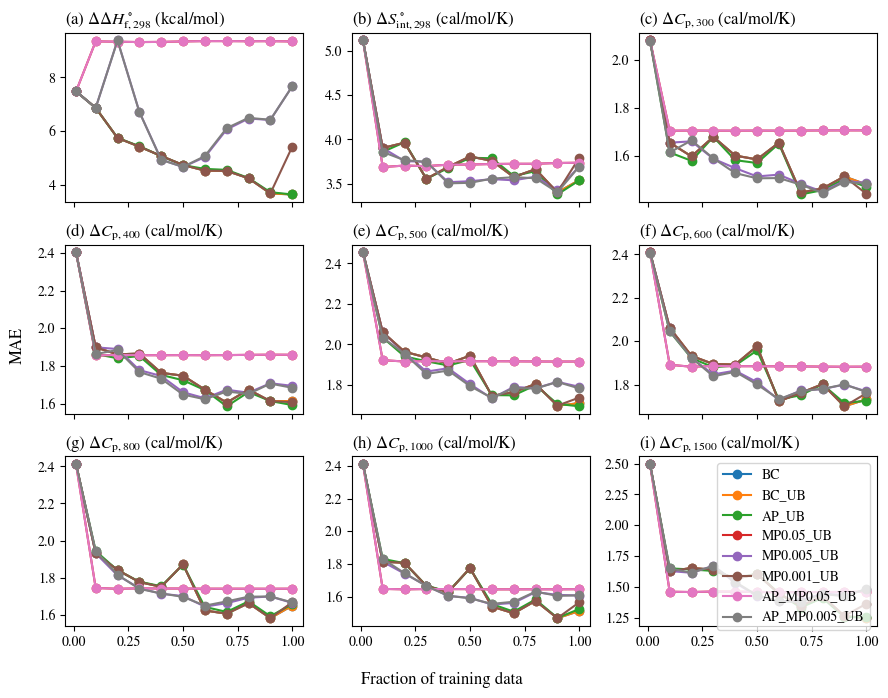

In [137]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))
bins = 20

for run_dir in run_dirs:
    ax = axs.flat[0]
    label = "mae_HBI_H298 (kcal/mol)"
    ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
    ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

    ax = axs.flat[1]
    label = "mae_HBI_Sint298 (cal/mol/K)"
    ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o")
    ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

    for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
        label = f"mae_HBI_Cp{T} (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], "-o", label=run_dirs[run_dir])
        ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/mae_vs_training_frac.pdf", bbox_inches="tight")

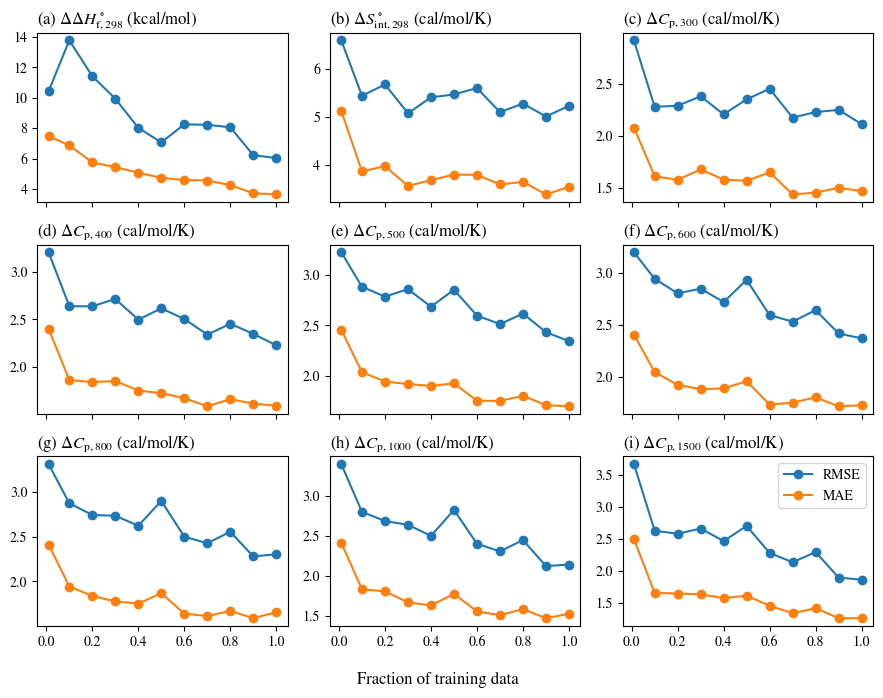

In [138]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))
bins = 20

run_dir = "../models/split-random_run-aleatoric_prepruning-upper_bound"

ax = axs.flat[0]
label = "HBI_H298 (kcal/mol)"
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o")
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o")
ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

ax = axs.flat[1]
label = "HBI_Sint298 (cal/mol/K)"
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o")
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o")
ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
    label = f"HBI_Cp{T} (cal/mol/K)"
    ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o", label="RMSE")
    ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o", label="MAE")
    ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
# fig.savefig("../figures/rmse_mae_vs_training_frac.pdf", bbox_inches="tight")